# Load Dataset from Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Mounted at /content/drive


# Import Libraries

In [2]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(42)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copyfile

In [3]:
dataset_dir = f"/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

In [4]:
def list_images():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    train_classes = os.listdir(os.path.join(train_dir, folder))
    validation_classes = os.listdir(os.path.join(validation_dir, folder))
    test_classes = os.listdir(os.path.join(test_dir, folder))
    print(f"{folder}: \n \t{len(train_classes)} train images, {len(validation_classes)} validation images, and {len(test_classes)} test images,  total {len(train_classes) + len(validation_classes) + len(test_classes)} images")
    print()
list_images()

Kersen: 
 	81 train images, 23 validation images, and 13 test images,  total 117 images

Pepaya: 
 	168 train images, 47 validation images, and 25 test images,  total 240 images

Lengkuas: 
 	72 train images, 20 validation images, and 11 test images,  total 103 images

Jambu Biji: 
 	154 train images, 44 validation images, and 23 test images,  total 221 images

Jeruk Purut: 
 	135 train images, 38 validation images, and 21 test images,  total 194 images

Mint: 
 	302 train images, 85 validation images, and 45 test images,  total 432 images

Kelor: 
 	153 train images, 43 validation images, and 23 test images,  total 219 images

Lemon: 
 	151 train images, 42 validation images, and 23 test images,  total 216 images

Nangka: 
 	108 train images, 31 validation images, and 16 test images,  total 155 images

Bayam Hijau: 
 	206 train images, 58 validation images, and 31 test images,  total 295 images

Mangga: 
 	304 train images, 86 validation images, and 45 test images,  total 435 images



In [7]:
# Load the first example of a horse
def image_shapes():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    if folder == "Jeruk Purut":
      continue
    classes = os.listdir(os.path.join(train_dir, folder))
    print(folder)
    sample_image  = load_img(f"{os.path.join(train_dir ,folder, classes[0])}")
    # # Convert the image into its numpy array representation
    sample_array = img_to_array(sample_image)
    print(f"Each {folder} image has shape: {sample_array.shape}")
image_shapes()

Kersen
Each Kersen image has shape: (474, 474, 3)
Pepaya
Each Pepaya image has shape: (500, 500, 3)
Lengkuas
Each Lengkuas image has shape: (1200, 1600, 3)
Jambu Biji
Each Jambu Biji image has shape: (492, 474, 3)
Mint
Each Mint image has shape: (462, 474, 3)
Kelor
Each Kelor image has shape: (465, 700, 3)
Lemon
Each Lemon image has shape: (4000, 6000, 3)
Nangka
Each Nangka image has shape: (559, 474, 3)
Bayam Hijau
Each Bayam Hijau image has shape: (400, 400, 3)
Mangga
Each Mangga image has shape: (4000, 6000, 3)
Basil
Each Basil image has shape: (4000, 6000, 3)


In [9]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                              rotation_range = 25,
                              zoom_range = [0.5, 1.1],
                              width_shift_range=0.15, 
                              shear_range= 0.15,
                              height_shift_range=0.15,
                              preprocessing_function=preprocess_input,
                              horizontal_flip=True,
                              vertical_flip= True,
                              fill_mode='nearest',)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64, 
                                                      class_mode='sparse',
                                                      shuffle=True,
                                                      seed=42, 
                                                      target_size=(225, 225))

  validation_datagen = ImageDataGenerator(rescale = 1/255,
                                          preprocessing_function=preprocess_input)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=64, 
                                                                class_mode='sparse',
                                                                shuffle=True,
                                                                seed=42,
                                                                target_size=(225, 225))
  ### END CODE HERE
  test_datagen = ImageDataGenerator(rescale= 1./255.)

  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=64,
                                                                shuffle=False, 
                                                                class_mode='sparse',
                                                                target_size=(224, 224))
  return train_generator, validation_generator, test_generator

In [10]:
train_generator, validation_generator, test_generator = train_val_generators(train_dir, validation_dir, test_dir)

Found 1876 images belonging to 12 classes.
Found 521 images belonging to 12 classes.
Found 275 images belonging to 12 classes.


In [11]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(225, 225, 3))
base_model.trainable = False ## Not trainable weights

## Preprocessing input

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(4096, activation='relu')
dense_layer_2 = layers.Dense(1072, activation='relu')
prediction_layer = layers.Dense(12, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


# es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


58900480/58889256 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 1072)              4391984   
                                                                 
 dense_2 (Dense)             (None, 12)                12876     
                                                                 
Total params: 121,884,092
Trainable params: 107,169,404
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
30/30 [==============================] - 1747s 58s/step - loss: 6.7541 - accuracy: 0.3124 - val_loss: 1.2011 - val_accuracy: 0.6372
Epoch 2/15
30/30 [==============================] - 261s 9s/step - loss: 1.0851 - accuracy: 0.6498 - val_loss: 0.7747 - val_accuracy: 0.7159
Epoch 3/15
30/30 [==============================] - 261s 9s/step - loss: 0.7799 - accuracy: 0.7319 - val_loss: 0.6837 - val_accuracy: 0.7620
Epoch 4/15
30/30 [==============================] - 262s 9s/step - loss: 0.6408 - accuracy: 0.7825 - val_loss: 0.5141 - val_accuracy: 0.8311
Epoch 5/15
30/30 [==============================] - 262s 9s/step - loss: 0.5480 - accuracy: 0.8225 - val_loss: 0.5475 - val_accuracy: 0.8253
Epoch 6/15
30/30 [==============================] - 263s 9s/step - loss: 0.4919 - accuracy: 0.8273 - val_loss: 0.4617 - val_accuracy: 0.8637
Epoch 7/15
30/30 [==============================] - 263s 9s/step - loss: 0.4859 - accuracy: 0.8241 - val_loss: 0.5252 - val_accuracy: 0.8426
Epoch 8/15


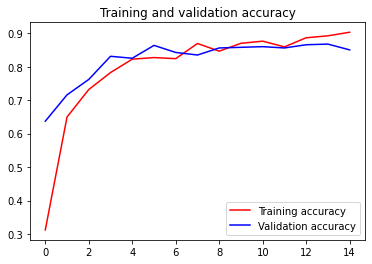

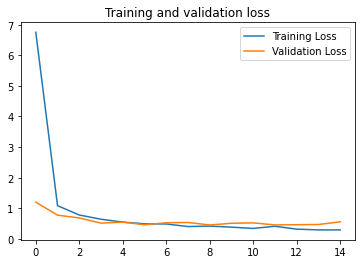

In [14]:
def plot_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(len(acc))
  
  plt.subplot()
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.subplot()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss,  label='Validation Loss')
  plt.legend()
  plt.show()
  
  plt.show()

plot_loss(history)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


5/5 [==============================] - 169s 40s/step - loss: 0.5975 - accuracy: 0.8182
Loss of the model is -  0.5974922180175781
Accuracy of the model is -  81.81818127632141 %
              precision    recall  f1-score   support

       Basil       1.00      0.94      0.97        16
 Bayam Hijau       0.92      0.79      0.85        29
  Jambu Biji       0.63      0.60      0.62        20
 Jeruk Purut       1.00      0.62      0.76        13
       Kelor       0.89      0.73      0.80        22
      Kersen       0.91      0.77      0.83        13
       Lemon       1.00      0.65      0.79        23
    Lengkuas       0.80      0.40      0.53        10
      Mangga       0.92      0.98      0.95        45
        Mint       0.78      0.93      0.85        45
      Nangka       0.47      0.93      0.62        15
      Pepaya       0.81      0.92      0.86        24

    accuracy                           0.82       275
   macro avg       0.84      0.77      0.79       275
weighted a

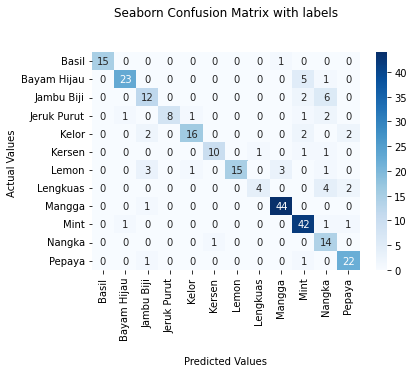

In [15]:
def evaluate_model(model, test_gen):
  evaluate = model.evaluate(test_gen)
  print('Loss of the model is - ', evaluate[0])
  print('Accuracy of the model is - ', evaluate[1]*100, '%')

  classes =  list(test_gen.class_indices.keys())
  Y_pred = model.predict(test_gen)
  y_pred = np.argmax(Y_pred, axis=1)
  
  print(classification_report(test_gen.classes, y_pred, target_names=classes))
  print('Confusion Matrix')
  conf_matrix = confusion_matrix(test_gen.classes, y_pred)
  df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
  ax = sns.heatmap(df_cm, annot=True, cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  
  ## Ticket labels - List must be in alphabetical order

evaluate_model(model, test_generator)

In [17]:
# vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

# vgg_preds_ft = vgg_model_ft.predict(testgen)
# vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

In [28]:
def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(225, 225))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [32]:
!wget https://previews.123rf.com/images/tharinsinlapachai/tharinsinlapachai1606/tharinsinlapachai160600101/60403746-close-up-of-guava-leaf-on-white-background.jpg -O guava2.jpg

--2022-05-20 13:07:37--  https://previews.123rf.com/images/tharinsinlapachai/tharinsinlapachai1606/tharinsinlapachai160600101/60403746-close-up-of-guava-leaf-on-white-background.jpg
Resolving previews.123rf.com (previews.123rf.com)... 54.192.19.54, 54.192.19.128, 54.192.19.46, ...
Connecting to previews.123rf.com (previews.123rf.com)|54.192.19.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99313 (97K) [image/jpeg]
Saving to: ‘guava2.jpg’

guava2.jpg          100%[===================>]  96.99K   233KB/s    in 0.4s    

2022-05-20 13:07:39 (233 KB/s) - ‘guava2.jpg’ saved [99313/99313]



In [ ]:
label_map = (train_generator.class_indices)
label_map = {v: k for k, v in label_map.items()}
image_path ='/content/Pas Foto Ramdhina Finita_resize.png'
image = load_image(image_path, show=True)
predict = model.predict(image)
print(label_map[np.argmax(model.predict(image))])
predicted_list = [ele * 100 for ele in predict.flatten()]

for idx, ele in enumerate(predicted_list):
  print(f"{label_map[idx]}: {ele}")

In [ ]:
train_generator.class_indices

{'Basil': 0,
 'Bayam Hijau': 1,
 'Jambu Biji': 2,
 'Jeruk Purut': 3,
 'Kelor': 4,
 'Kersen': 5,
 'Lemon': 6,
 'Lengkuas': 7,
 'Mangga': 8,
 'Mint': 9,
 'Nangka': 10,
 'Pepaya': 11}

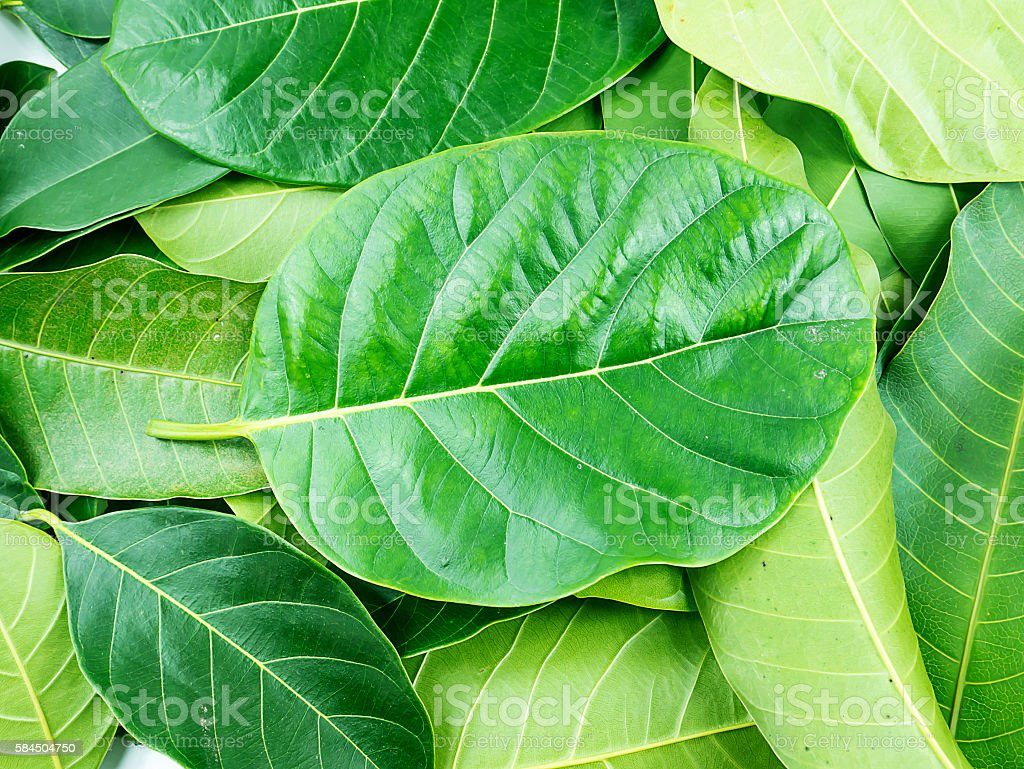

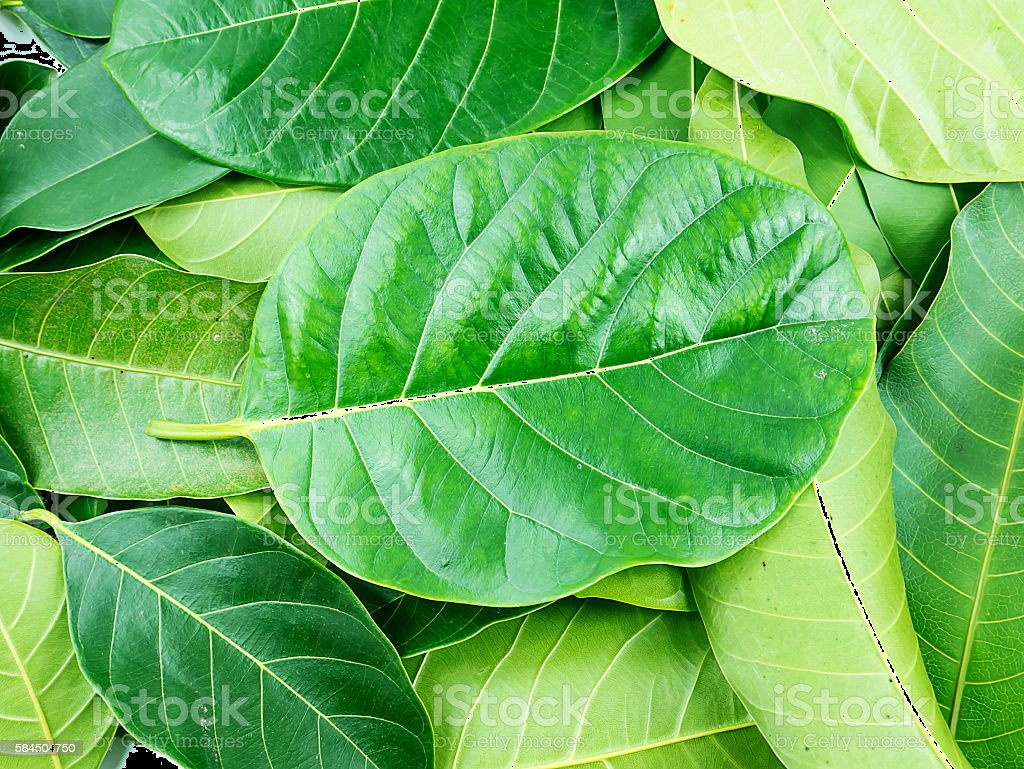

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img =  cv2.imread('/istockphoto-584504750-1024x1024.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# find the green color 
mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
# find the brown color
mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
# find the yellow color in the leaf
mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

# find any of the three colors(green or brown or yellow) in the image
mask = cv2.bitwise_or(mask_green, mask_brown)
mask = cv2.bitwise_or(mask, mask_yellow)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask= mask)

cv2_imshow(img)
cv2_imshow(res)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
train_generator.class_indices

{'Bayam Hijau': 0,
 'Jahe': 1,
 'Jambu Biji': 2,
 'Jeruk Purut': 3,
 'Kelor': 4,
 'Kersen': 5,
 'Lemon': 6,
 'Lengkuas': 7,
 'Mint': 8,
 'Nangka': 9,
 'Pepaya': 10}